## FWF and point cloud data alignment

*Align each pulse in the PulseWaves file with its returns in the point cloud file*

### Preparation

Fetch the data from the SDR if you do not have them locally. Otherwise, set the local file pathss in the next code block.

In [1]:
project='sp19' # project name, 'd15' for Dublin 2015 or 'sp19' for Sunset Park 2019
line='161348' # flight line number, get from the index map or the bitstreams.json or the meta.json files

# fetch point cloud
!../scripts/fetch.sh $project $line pc

# fetch pulsewaves
!../scripts/fetch.sh $project $line fwf-pw

# convert a segment of the pulsewaves file to pwmsg format
!mkdir -p ../data/pwmsg
!java -jar "../jar/umg-cli-0.2.0-SNAPSHOT-jar-with-dependencies.jar" pw2proto -idir ../data/fwf-pw -odir ../data/pwmsg -meta_file ../data/metadata/$project-meta.json -segment 100000 -subseq 0 5000

--2020-08-01 11:49:41--  https://archive.nyu.edu/bitstream/2451/60462/4/nyu_2451_60462_pc_FD_190511_161348.zip
Resolving archive.nyu.edu (archive.nyu.edu)... 128.122.108.142
Connecting to archive.nyu.edu (archive.nyu.edu)|128.122.108.142|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 41456706 (40M) [application/octet-stream]
Saving to: ‘tmp1596278981.24175/nyu_2451_60462_pc_FD_190511_161348.zip’

nyu_2451_60462_pc_F 100%[===================>]  39.54M  12.6MB/s    in 3.3s    

2020-08-01 11:49:45 (11.9 MB/s) - ‘tmp1596278981.24175/nyu_2451_60462_pc_FD_190511_161348.zip’ saved [41456706/41456706]

Archive:  tmp1596278981.24175/nyu_2451_60462_pc_FD_190511_161348.zip
  inflating: tmp1596278981.24175/nyu_2451_60462_pc_FD_190511_161348/1552_NYU_M2-Scanner1-190511_161348_1-originalpoints.laz  
moving tmp1596278981.24175/nyu_2451_60462_pc_FD_190511_161348/1552_NYU_M2-Scanner1-190511_161348_1-originalpoints.laz to ../

The paths below must be set manually.

In [2]:
# pulsewaves file
plswvs_fname = '../data/fwf-pw/10552_NYU_M2_Pulse_Waves_MTA_Resolved-Scanner1-190511_161348_1-originalpoints.pls'

# pwmsg file
pwmsg_fname = '../data/pwmsg/10552_NYU_M2_Pulse_Waves_MTA_Resolved-Scanner1-190511_161348_1-originalpoints-0.pwmsg'

# point cloud file
pc_fname = '../data/pc-laz/1552_NYU_M2-Scanner1-190511_161348_1-originalpoints.laz'

# check if the paths are valid
!ls $plswvs_fname
!ls $pwmsg_fname
!ls $pc_fname

../data/fwf-pw/10552_NYU_M2_Pulse_Waves_MTA_Resolved-Scanner1-190511_161348_1-originalpoints.pls
../data/pwmsg/10552_NYU_M2_Pulse_Waves_MTA_Resolved-Scanner1-190511_161348_1-originalpoints-0.pwmsg
../data/pc-laz/1552_NYU_M2-Scanner1-190511_161348_1-originalpoints.laz


Dependencies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from laspy.file import File
import pypwaves.base as pypwaves

from als.pulsewaves import PulseWaves
from als.mess import get_points_by_time_brute_force as get_points

from datetime import datetime
from als.base import GPSTimeUtil
timeutil = GPSTimeUtil(flight_date = datetime(2019, 5, 11))

### Data parsing

Data parsing is required only once. This does not need to be rerun for each pulse index.

In [4]:
pw = PulseWaves(pwmsg_fname)
ppw = pypwaves.openPLS(plswvs_fname)
pcloud = File(pc_fname, mode = "r")

### Pulse index

Change the pusle index and run the subsequent code blocks to observe the pulse

In [5]:
pls_idx = 0

### The pulse in the PWMsg file

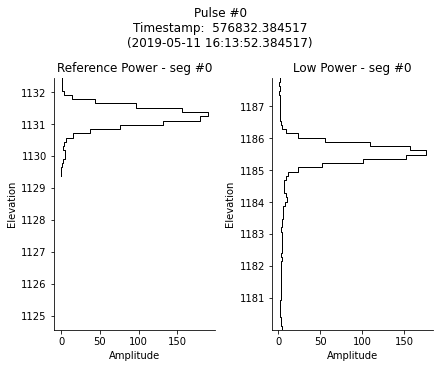

In [6]:
# get the pulse given the index
pulse = pw.get_pulse(pls_idx)

# compute the timestamp of the pulse to match with the point cloud returns
timestamp = pulse.timestamp * pw.scale.loc['t']['scale'] + pw.scale.loc['t']['offset']

# plot the waves
fig, axes = pw.plot_waves(pulse, title = 'Pulse #{0}\nTimestamp: {1: .6f}\n({2})'.format(pls_idx, timestamp, timeutil.gpstime_to_datetime(timestamp)))

The majority of the peaks in the returning samplings (i.e. Low Power and High Power channels) should be around 100 - 200 ft (i.e. returns from ground, trees, buildings). However, many of the peaks seen in the data are abnormally high. Many of them are higher than the helicopter's altitude. Looking closer at the data, I find that the values of the following fields are abnormal: 
    * `duration from anchor`
    * `first returning sample`
    * `last returning sample`

### The pulse in the PulseWaves file

To double check the waves seen in the PWMsg file, look at the waves as parsed using [PyPWaves](pypwaves).

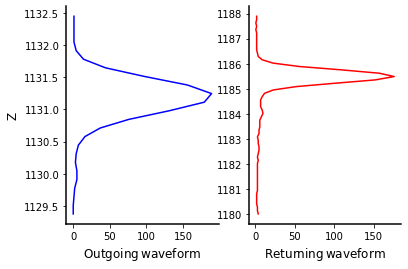

In [7]:
waves = ppw.get_waves(pulse_record = pls_idx)
waves.plot()

The waves parsed by PWMsg and PyPWaves match. The only difference is that PyWaves does not show all the segments and channels.

### The corresponding returns

Retrieve the returns in the point cloud that match the pulse's timestamp. 

Note that a correction factor is applied to acount for the difference in timestamp encoding in the PulseWaves and the point cloud files.

In [8]:
corr = 6*24*60*60-18
t = timestamp - corr
full_idx = np.arange(len(pcloud))
diff =  np.abs(pcloud.gps_time - t)
diff_min = np.min(diff)
mask = diff == diff_min
idx = full_idx[mask]

pts = pd.DataFrame({
    'x': [ pcloud.get_x_scaled()[i] for i in idx ],
    'y': [ pcloud.get_y_scaled()[i] for i in idx ],
    'z': [ pcloud.get_z_scaled()[i] for i in idx ],
    'intensity': [ pcloud.get_intensity()[i] for i in idx ],
    'return_num': [ pcloud.get_return_num()[i] for i in idx ],
    'num_return': [ pcloud.get_num_returns()[i] for i in idx ],
    'timestamp': [ pcloud.get_gps_time()[i] for i in idx ],
    'corrected_timestamp': [ pcloud.get_gps_time()[i] + corr for i in idx ],
}, index = idx
)

pts

,x,y,z,intensity,return_num,num_return,timestamp,corrected_timestamp
440007,979884.627,172620.644,116.285,1227,1,2,58450.384517,576832.384517
440008,979665.203,172597.332,-320.712,124,2,2,58450.384517,576832.384517


### Conclusion

Two problems seeen:

1. Time encoding is different in the waveform files and the point cloud files.

2. The pulses are not georeferenced correctly.